In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F #for activation functions
from torch.optim import SGD  #gradient descent
import lightning as L

import matplotlib.pyplot as plt
import seaborn as sns


Everything is the same except you inherit from Lightning module. However, we need to configure

In [60]:
#with pytorch we start by creating a new class for a neural network

#inherits from pytorch class called moduele
class BasicNNLightning(L.LightningModule): 
    #initializatoin method for parrent class
    def __init__(self):
        super().__init__()
        #create new var for weight, make it a neural network parameter == give option to optimize, requires gradient = false
        #since its a tensor neural network can take advantage of automatic differentian it provides
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad= False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad= False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad= False)
        self.b10 = nn.Parameter(torch.tensor(0), requires_grad= False)

        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad= False)
        self.w11 = nn.Parameter(torch.tensor(2.70), requires_grad= False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=True)
        self.learning_rate = 0.01

    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu = bottom_relu_output * self.w11

        input_to_final = scaled_bottom_relu + scaled_top_relu + self.final_bias

        output = F.relu(input_to_final)
        return output

    #optimizes nerual network
    def configure_optimizers(self):
        return SGD(self.parameters(), lr = self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        input_i ,label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i -label_i)**2
        return loss
    



In [61]:
input_doses = torch.linspace(start = 0, end = 1, steps = 11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [62]:
inputs = torch.tensor([0., 0.5, 1.])
labels = torch.tensor([0., 1., 0.])

In [63]:
from torch.utils.data import TensorDataset, DataLoader


dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [64]:
import lightning as L
print(L.__version__)


2.4.0


In [65]:
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner

# Initialize the model
model = BasicNNLightning()

# Initialize the trainer
trainer = Trainer(max_epochs=34)  # No need for L.Trainer; use Trainer directly

# Initialize the tuner
tuner = Tuner(trainer)  # No need for L.Tuner; use Tuner directly

# Perform learning rate finding
lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=dataloader,  # Correct parameter name
    min_lr=0.001,
    max_lr=0.1,
    early_stop_threshold=None
)

# Suggest a new learning rate
new_lr = lr_find_results.suggestion()
print(f"lr_find suggests {new_lr:.5f} for the learning rate")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /Users/naomigong/Coding/ML Projects/Pytorch_Quest/.lr_find_b0c1a45e-0abd-4104-a98c-c0c4fec1b21c.ckpt
Restored all states from the checkpoint at /Users/naomigong/Coding/ML Projects/Pytorch_Quest/.lr_find_b0c1a45e-0abd-4104-a98c-c0c4fec1b21c.ckpt


lr_find suggests 0.00166 for the learning rate


In [66]:
model.learning_rate = new_lr

Now we train the model

In [67]:
#the trainer will call our model's configure optimizers <-- configure gradient descent with new lr
#then it calls trainig_step and also calls optimizer.zero_grad, loss.backward() and optimizer.step. 
#it repeats by calling training_step
#WITH LIGHTNING NO NEED FOR BIG LOOP
trainer.fit(model, train_dataloaders= dataloader)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=34` reached.


In [68]:
print(model.final_bias)

Parameter containing:
tensor(-16.0011, requires_grad=True)


Text(0.5, 0, 'Dosage')

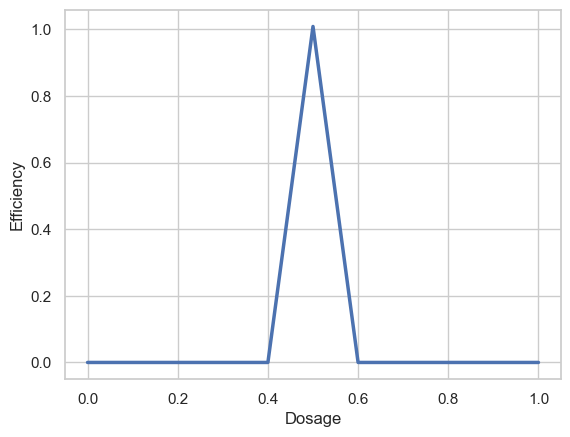

In [69]:
output_values = model(input_doses)

sns.set(style = "whitegrid")
sns.lineplot(x = input_doses, 
             y = output_values.detach(),
             linewidth = 2.5)

plt.ylabel("Efficiency")
plt.xlabel("Dosage")